In [50]:
# Foundations of Data Science 
# Members: Tashrif Chowdhury (tc2367), Terrell Nowlin (trn224), Akhilesh Chandrashekar (ab10138), Zhenghao Li(zl3954), 
#          Faiz Andrea Ganz (fag277)
# Yelp Reviews: Fraud Detection
# December 9th, 2021

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, f1_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string

%matplotlib inline

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('reviewContent', sep="\t", names=['user_id', 'prod_id', 'date', 'review'])
meta = pd.read_csv('metadata', sep='\t', names = ['user_id', 'prod_id', 'rating', 'label', 'date'])

df = pd.merge(data, meta, on = ['user_id', 'date', 'prod_id'])

df.loc[df.label == 1, 'label'] = 0
df.loc[df.label == -1, 'label'] = 1

# Include other features as text
df.loc[df.label == 0, 'review'] = '#user_id:' + (df.loc[df.label == 0, 'user_id'].astype(str) + ' '
                                + '#prod_id:' + df.loc[df.label == 0, 'prod_id'].astype(str) + ' '
                                + '#date:' + df.loc[df.label == 0, 'date'].astype(str) + ' '
                                + '#rating:' + df.loc[df.label == 0, 'rating'].astype(str) + ' '
                                + '#review:' + df.loc[df.label == 0, 'review'])

df.loc[df.label == 1, 'review'] = '#user_id:' + (df.loc[df.label == 1, 'user_id'].astype(str) + ' '
                                + '#prod_id:' + df.loc[df.label == 1, 'prod_id'].astype(str) + ' '
                                + '#date:' + df.loc[df.label == 1, 'date'].astype(str) + ' '
                                + '#rating:' + df.loc[df.label == 1, 'rating'].astype(str) + ' '
                                + '#review:' + df.loc[df.label == 1, 'review'])

df = df[['review', 'label']]

In [4]:
# Get X and y values
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [6]:
# Oversampling on training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [45]:
y_resampled.value_counts()

0    215805
1    215805
Name: label, dtype: int64

In [46]:
len(y_resampled)

431610

In [7]:
# CountVectorizer

cv = CountVectorizer(stop_words="english", ngram_range=(1,2), binary=True)

X_train_cv = cv.fit_transform(X_resampled.review.values.tolist())
X_test_cv = cv.transform(X_test.review.values.tolist())

In [8]:
# TfidfVectorizer

tf_idf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), binary=True)

X_train_tf_idf = tf_idf.fit_transform(X_resampled.review.values.tolist())
X_test_tf_idf = tf_idf.transform(X_test.review.values.tolist())

In [9]:
# Logistic Regression - CountVectorizer
# lr_cv = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_cv = LogisticRegression(max_iter=1000)
lr_cv.fit(X_train_cv, y_resampled)
y_pred_lr_cv = lr_cv.predict_proba(X_test_cv)
y_predictions_lr_cv = lr_cv.predict(X_test_cv)
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = metrics.roc_curve(y_test, y_pred_lr_cv[:,1], pos_label = 1)
roc_auc_score_lr_cv = metrics.auc(fpr_lr_cv, tpr_lr_cv)

print(accuracy_score(y_test,y_predictions_lr_cv))
print(classification_report(y_test,y_predictions_lr_cv))

0.8875109745390694
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    106292
           1       0.42      0.27      0.33     12164

    accuracy                           0.89    118456
   macro avg       0.67      0.61      0.63    118456
weighted avg       0.87      0.89      0.88    118456



In [39]:
print('Testing F1 score: {}'.format(metrics.f1_score(y_test, y_predictions_lr_cv, average='weighted')))
print('Testing AUC score: {}'.format(metrics.auc(fpr_lr_cv, tpr_lr_cv)))

Testing F1 score: 0.8759862116941679
Testing AUC score: 0.7643797141625943


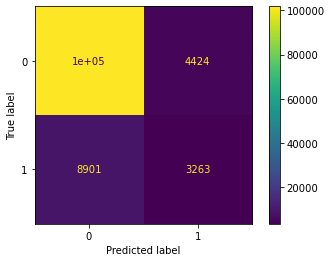

In [10]:
cfm = confusion_matrix(y_test, y_predictions_lr_cv)
display = ConfusionMatrixDisplay(cfm, display_labels = [0, 1])
display.plot()
plt.show()

In [11]:
# Logistic Regression - TfidfVectorizer
# lr_tf_idf = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_tf_idf = LogisticRegression(max_iter=1000)
lr_tf_idf.fit(X_train_tf_idf, y_resampled)
y_pred_lr_tf_idf = lr_tf_idf.predict_proba(X_test_tf_idf)
y_predictions_lr_tf_idf = lr_tf_idf.predict(X_test_tf_idf)
fpr_lr_tf_idf, tpr_lr_tf_idf, thresholds_lr_tf_idf = metrics.roc_curve(y_test, y_pred_lr_tf_idf[:,1], pos_label = 1)
roc_auc_score_lr_tf_idf = metrics.auc(fpr_lr_tf_idf, tpr_lr_tf_idf)


In [40]:
print('Testing F1 score: {}'.format(metrics.f1_score(y_test, y_predictions_lr_tf_idf, average='weighted')))
print('Testing AUC score: {}'.format(metrics.auc(fpr_lr_tf_idf, tpr_lr_tf_idf)))

Testing F1 score: 0.8107888253351524
Testing AUC score: 0.7861240289897499


0.7731562774363476
              precision    recall  f1-score   support

           0       0.95      0.79      0.86    106292
           1       0.26      0.63      0.36     12164

    accuracy                           0.77    118456
   macro avg       0.60      0.71      0.61    118456
weighted avg       0.88      0.77      0.81    118456



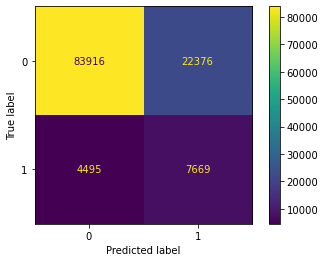

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(accuracy_score(y_test,y_predictions_lr_tf_idf))
print(classification_report(y_test,y_predictions_lr_tf_idf))

cfm = confusion_matrix(y_test.tolist(), y_predictions_lr_tf_idf.tolist())
display = ConfusionMatrixDisplay(cfm, display_labels = [0, 1])
display.plot()
plt.show()

In [13]:
# BernoulliNB - CountVectorizer
nb_cv = BernoulliNB()
nb_cv.fit(X_train_cv, y_resampled)
y_pred_nb_cv = nb_cv.predict_proba(X_test_cv)
y_predictions_nb_cv = nb_cv.predict(X_test_cv)
fpr_nb_cv, tpr_nb_cv, thresholds_nb_cv = metrics.roc_curve(y_test, y_pred_nb_cv[:,1], pos_label = 1)
roc_auc_score_nb_cv = metrics.auc(fpr_nb_cv, tpr_nb_cv)

0.6108597285067874
              precision    recall  f1-score   support

           0       0.95      0.60      0.73    106292
           1       0.17      0.72      0.28     12164

    accuracy                           0.61    118456
   macro avg       0.56      0.66      0.51    118456
weighted avg       0.87      0.61      0.69    118456



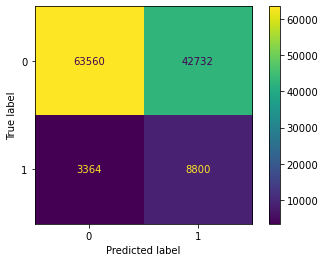

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(accuracy_score(y_test,y_predictions_nb_cv))
print(classification_report(y_test,y_predictions_nb_cv))

confusion_matrix = confusion_matrix(y_test, y_predictions_nb_cv)
display = ConfusionMatrixDisplay(confusion_matrix, display_labels = [0, 1])
display.plot()
plt.show()

In [41]:
print('Testing F1 score: {}'.format(metrics.f1_score(y_test, y_predictions_nb_cv, average='weighted')))
print('Testing AUC score: {}'.format(metrics.auc(fpr_nb_cv, tpr_nb_cv)))

Testing F1 score: 0.68689459774471
Testing AUC score: 0.7315817452968713


In [15]:
# BernoulliNB - TfidfVectorizer
nb_tf_idf = BernoulliNB()
nb_tf_idf.fit(X_train_tf_idf, y_resampled)
y_pred_nb_tf_idf = nb_tf_idf.predict_proba(X_test_tf_idf)
y_predictions_nb_tf_idf = nb_tf_idf.predict(X_test_tf_idf)
fpr_nb_tf_idf, tpr_nb_tf_idf, thresholds_nb_tf_idf = metrics.roc_curve(y_test, y_pred_nb_tf_idf[:,1], pos_label = 1)
roc_auc_score_nb_tf_idf = metrics.auc(fpr_nb_tf_idf, tpr_nb_tf_idf)


0.6108597285067874
              precision    recall  f1-score   support

           0       0.95      0.60      0.73    106292
           1       0.17      0.72      0.28     12164

    accuracy                           0.61    118456
   macro avg       0.56      0.66      0.51    118456
weighted avg       0.87      0.61      0.69    118456



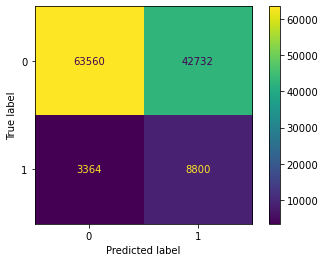

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(accuracy_score(y_test,y_predictions_nb_tf_idf))
print(classification_report(y_test,y_predictions_nb_tf_idf))

confusion_matrix = confusion_matrix(y_test, y_predictions_nb_tf_idf.tolist())
display = ConfusionMatrixDisplay(confusion_matrix, display_labels = [0, 1])
display.plot()
plt.show()

In [42]:
print('Testing F1 score: {}'.format(metrics.f1_score(y_test, y_predictions_nb_tf_idf, average='weighted')))
print('Testing AUC score: {}'.format(metrics.auc(fpr_nb_tf_idf, tpr_nb_tf_idf)))

Testing F1 score: 0.68689459774471
Testing AUC score: 0.7315817452968713


In [37]:
# RandomForest ROC Curve Stats, included 

fpr_rf_tf_idf = [0.00000000e+00, 1.11333779e-04, 3.34001336e-04, 5.56668893e-04,
       8.90670229e-04, 1.22467157e-03, 1.89267424e-03, 2.44934313e-03,
       3.45134714e-03, 4.89868626e-03, 7.34802939e-03, 1.10220441e-02,
       1.35827210e-02, 1.87040748e-02, 2.51614340e-02, 3.05054554e-02,
       3.77421510e-02, 4.64261857e-02, 5.54442218e-02, 6.56869294e-02,
       7.52616344e-02, 8.82876865e-02, 9.98663995e-02, 1.12224449e-01,
       1.26475173e-01, 1.40837230e-01, 1.57314629e-01, 1.70674683e-01,
       1.88042752e-01, 2.03852149e-01, 2.21776887e-01, 2.39924293e-01,
       2.57737698e-01, 2.74883100e-01, 2.93475841e-01, 3.12513917e-01,
       3.30549989e-01, 3.50701403e-01, 3.70630149e-01, 3.90336228e-01,
       4.10932977e-01, 4.30193721e-01, 4.47561790e-01, 4.67935872e-01,
       4.89423291e-01, 5.09797373e-01, 5.29392118e-01, 5.45758183e-01,
       5.63905589e-01, 5.83611668e-01, 6.00979737e-01, 6.17791138e-01,
       6.33266533e-01, 6.50411935e-01, 6.67557337e-01, 6.84034736e-01,
       7.02627477e-01, 7.17768871e-01, 7.32353596e-01, 7.46381652e-01,
       7.63415720e-01, 7.78891116e-01, 7.93809842e-01, 8.09396571e-01,
       8.24871966e-01, 8.38120686e-01, 8.52594077e-01, 8.67178802e-01,
       8.80984191e-01, 8.92451570e-01, 9.04252950e-01, 9.17501670e-01,
       9.28969049e-01, 9.40102427e-01, 9.58583834e-01, 9.65597862e-01,
       9.71387219e-01, 9.77510577e-01, 9.83522601e-01, 9.87196615e-01,
       9.91315965e-01, 9.93987976e-01, 9.96103318e-01, 9.97550657e-01,
       9.98775328e-01, 9.99554665e-01, 9.99777332e-01, 1.00000000e+00]
tpr_rf_tf_idf = [0.        , 0.        , 0.00196464, 0.00491159, 0.00785855,
       0.00982318, 0.01375246, 0.01669941, 0.02848723, 0.03634578,
       0.043222  , 0.05795678, 0.06286837, 0.07760314, 0.09332024,
       0.11591356, 0.14243615, 0.16306483, 0.18860511, 0.20628684,
       0.23084479, 0.25736739, 0.27996071, 0.29960707, 0.3280943 ,
       0.35363458, 0.36738703, 0.39685658, 0.42632613, 0.44990177,
       0.47642436, 0.50098232, 0.53045187, 0.55304519, 0.57563851,
       0.58840864, 0.61394892, 0.6345776 , 0.65324165, 0.67288802,
       0.69548134, 0.71316306, 0.72986248, 0.75049116, 0.76817289,
       0.78290766, 0.79666012, 0.80746562, 0.81139489, 0.82711198,
       0.84184676, 0.85265226, 0.86640472, 0.8762279 , 0.88310413,
       0.88998035, 0.90078585, 0.9086444 , 0.91257367, 0.91846758,
       0.92829077, 0.93516699, 0.94302554, 0.94891945, 0.956778  ,
       0.96168959, 0.96660118, 0.96660118, 0.97053045, 0.97151277,
       0.978389  , 0.98035363, 0.98330059, 0.98624754, 0.99214145,
       0.99410609, 0.99508841, 0.99705305, 0.99803536, 0.99901768,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ]
fpr_rf_cv = [0.00000000e+00, 3.34001336e-04, 8.90670229e-04, 1.11333779e-03,
       1.78134046e-03, 3.34001336e-03, 4.78735248e-03, 6.45735916e-03,
       8.01603206e-03, 1.05767090e-02, 1.34713872e-02, 1.60320641e-02,
       1.94834113e-02, 2.27120908e-02, 2.70541082e-02, 3.17301269e-02,
       3.85214874e-02, 4.49788466e-02, 5.15475395e-02, 5.81162325e-02,
       6.53529281e-02, 7.13649521e-02, 7.91583166e-02, 8.71743487e-02,
       9.48563794e-02, 1.04653752e-01, 1.15564462e-01, 1.26475173e-01,
       1.38276553e-01, 1.49966600e-01, 1.62769984e-01, 1.75239368e-01,
       1.86818081e-01, 1.98842129e-01, 2.13204186e-01, 2.26341572e-01,
       2.39701625e-01, 2.55065687e-01, 2.70318415e-01, 2.88131819e-01,
       3.03607214e-01, 3.19639279e-01, 3.36673347e-01, 3.56936094e-01,
       3.77978179e-01, 3.99131597e-01, 4.37207749e-01, 4.58027165e-01,
       4.78401247e-01, 4.98218660e-01, 5.18036072e-01, 5.39300824e-01,
       5.58784235e-01, 5.81384992e-01, 6.06991761e-01, 6.29481185e-01,
       6.52193275e-01, 6.74682699e-01, 6.98285460e-01, 7.22110888e-01,
       7.45045647e-01, 7.65865063e-01, 7.89022489e-01, 8.10621242e-01,
       8.32108662e-01, 8.50478735e-01, 8.68403474e-01, 8.88666221e-01,
       9.04698285e-01, 9.21287018e-01, 9.36094411e-01, 9.48118459e-01,
       9.59140503e-01, 9.68715208e-01, 9.76619906e-01, 9.83077266e-01,
       9.87975952e-01, 9.90870630e-01, 9.95101314e-01, 9.97327989e-01,
       9.98663995e-01, 9.99220664e-01, 9.99888666e-01, 1.00000000e+00]
tpr_rf_cv = [0.00000000e+00, 9.82318271e-04, 1.96463654e-03, 3.92927308e-03,
       6.87622790e-03, 2.45579568e-02, 2.94695481e-02, 4.32220039e-02,
       5.00982318e-02, 6.09037328e-02, 7.36738703e-02, 8.74263261e-02,
       1.00196464e-01, 1.14931238e-01, 1.25736739e-01, 1.37524558e-01,
       1.52259332e-01, 1.65029470e-01, 1.77799607e-01, 1.96463654e-01,
       2.14145383e-01, 2.34774067e-01, 2.55402750e-01, 2.79960707e-01,
       2.95677800e-01, 3.11394892e-01, 3.36935167e-01, 3.55599214e-01,
       3.84086444e-01, 3.99803536e-01, 4.21414538e-01, 4.32220039e-01,
       4.55795678e-01, 4.66601179e-01, 4.83300589e-01, 4.99017682e-01,
       5.13752456e-01, 5.37328094e-01, 5.54027505e-01, 5.74656189e-01,
       5.97249509e-01, 6.22789784e-01, 6.42436149e-01, 6.66011788e-01,
       6.86640472e-01, 7.02357564e-01, 7.43614931e-01, 7.58349705e-01,
       7.73084479e-01, 7.88801572e-01, 8.02554028e-01, 8.16306483e-01,
       8.34970530e-01, 8.48722986e-01, 8.64440079e-01, 8.73280943e-01,
       8.83104126e-01, 8.91944990e-01, 9.05697446e-01, 9.12573674e-01,
       9.22396857e-01, 9.36149312e-01, 9.45972495e-01, 9.55795678e-01,
       9.61689587e-01, 9.68565815e-01, 9.75442043e-01, 9.78388998e-01,
       9.81335953e-01, 9.83300589e-01, 9.89194499e-01, 9.91159136e-01,
       9.93123772e-01, 9.96070727e-01, 9.97053045e-01, 9.99017682e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]
roc_auc_score_rf_tf_idf = 0.6960147100575305
roc_auc_score_rf_cv = 0.7098853896397904

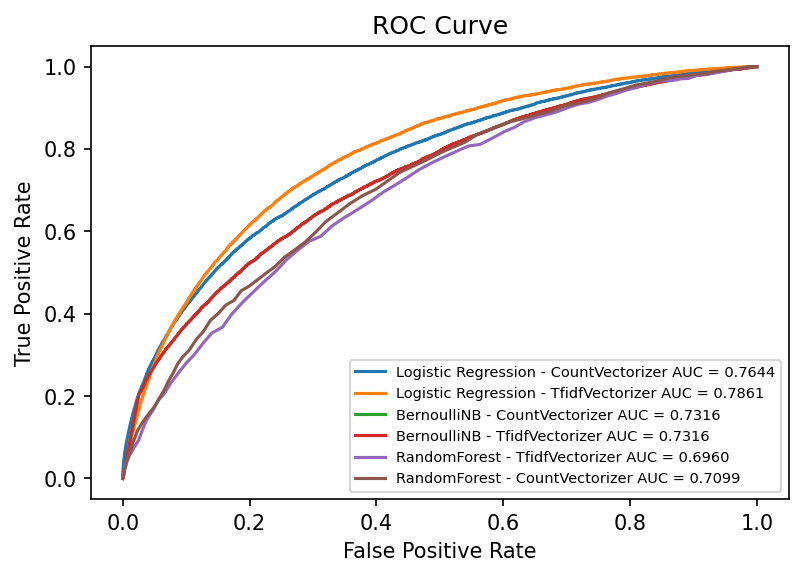

In [38]:
#Plot
plt.rcParams['figure.dpi'] = 150
plt.plot(fpr_lr_cv, tpr_lr_cv, label="Logistic Regression - CountVectorizer AUC = {:.4f}".format(roc_auc_score_lr_cv))
plt.plot(fpr_lr_tf_idf, tpr_lr_tf_idf, label="Logistic Regression - TfidfVectorizer AUC = {:.4f}".format(roc_auc_score_lr_tf_idf))
plt.plot(fpr_nb_cv, tpr_nb_cv, label="BernoulliNB - CountVectorizer AUC = {:.4f}".format(roc_auc_score_nb_cv))
plt.plot(fpr_nb_tf_idf, tpr_nb_tf_idf, label="BernoulliNB - TfidfVectorizer AUC = {:.4f}".format(roc_auc_score_nb_tf_idf))
plt.plot(fpr_rf_tf_idf, tpr_rf_tf_idf, label="RandomForest - TfidfVectorizer AUC = {:.4f}".format(roc_auc_score_rf_tf_idf))
plt.plot(fpr_rf_cv, tpr_rf_cv, label="RandomForest - CountVectorizer AUC = {:.4f}".format(roc_auc_score_rf_cv))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right', fontsize=7)
plt.show()

# Parameter Tuning

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [20]:
lg_params = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

In [21]:
search = RandomizedSearchCV(lr_cv, lg_params, scoring='accuracy')

In [22]:
result = search.fit(X_train_cv, y_resampled)

In [23]:
 # summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9796297583466554
Best Hyperparameters: {'C': 100}


In [24]:
grid_pred = result.best_estimator_.predict(X_test_tf_idf)

In [47]:
print('Testing accuracy %s' % accuracy_score(y_test, grid_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, grid_pred, average='weighted')))

Testing accuracy 0.9030948200175593
Testing F1 score: 0.8637227925083576


In [49]:
fpr, tpr, thresholds = roc_curve(y_test, grid_pred, pos_label = 1)
print('Testing AUC score: {}'.format(auc(fpr, tpr)))

Testing AUC score: 0.5319789483637567


In [27]:
search = RandomizedSearchCV(lr_cv, lg_params, scoring='roc_auc')

In [28]:
result = search.fit(X_train_cv, y_resampled)

In [29]:
 # summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9992871796579085
Best Hyperparameters: {'C': 100}


In [30]:
grid_pred = result.best_estimator_.predict(X_test_tf_idf)

In [31]:
print('Testing accuracy %s' % accuracy_score(y_test, grid_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, grid_pred, average='weighted')))
fpr, tpr, thresholds = roc_curve(y_test, grid_pred, pos_label = 1)
print('Testing AUC score: {}'.format(auc(fpr, tpr)))

Testing accuracy 0.9030948200175593
Testing F1 score: 0.8637227925083576
Testing AUC score: 0.5319789483637567
